# Trabajo final de Estadística Aplicada
```
   Alumno: Emiliano López
   Centro de Estudios HidroAmbientales (CENEHA)
   FICH - UNL

   Docentes: Diego Tomassi / Antonella Gieco
   FIQ-UNL
```

In [29]:
library(car)

# Motivación

- En el estudio de fenómenos hidrológicos o ambientales es indispensable contar con mediciones in situ

- En general son usados: alimentar modelos de simulación, calibrar parámetros, comprender la dinámica de los fenómenos, etc

- Frecuentemente son necesarios dispositivos de medición de diferentes fabricantes y elevado costo

- Dificulta el mantenimiento e integración, impactando en la resolución espacial y temporal

**Desarrollos propios con sensores de bajo costo**

- El CENEHA comenzó a desarrollar dispositivos basados en hardware libre (de código abierto)
- Costo de un orden de magnitud menor frente a alternativas comerciales/cerradas

***

<center>
    <img src="img/sensores.png" alt="drawing" width="550"/>
    <img src="img/combo-lab-campo.png" alt="drawing" width="950"/>
</center>

**Mejorar la resolución espacial y temporal**

***

<center>
<img src="img/sfe1.png" alt="drawing" width="500"/>
</center>

# Objetivo 

- Determinar si un sensor de bajo costo puede ser considerado confiable para reemplazar al sensor comercial equivalente


**Variables analizadas**

- Altura del Río Parana: Hidrómetro CENEHA vs Prefectura
- Temperatura ambiente: DHT22 vs Eddy Covariance
- Humedad ambiente: DHT22 vs Eddy Covariance
- Temperatura de suelo: DS18B20 vs Stevens

# Metodología

- Preprocesamiento de los datos
- Análisis exploratorio: gráfica y numéricamente
- Corroborar existencia de una correlacion serial positiva
    - Gráfico de rachas
    - Gráfico de residuos adyacentes: puntos en 1er y 3er cuadrante
- Regresión con **variables filtradas** para deshacernos de la correlación
    - crear nuevas variables respuestas y explicativas tales que el coeficiente de regresión sea el mismo pero que los **residuos sean independientes**
- Test: armar IC de la pendiente del modelo lineal ($\beta_1$) que incluya al 1

## Modelo lineal

$$Y_t = \beta_0 + \beta_1 X_t + \epsilon_t$$

- $\epsilon \sim $ Modelo Auto Regresivo 1 (AR1):

$$\epsilon_t = \alpha \epsilon_{t-1} + \nu_t$$

donde $\alpha$ **coeficiente de correlación serial** poblacional que será aproximado con $r_1$ (muestral)

Hipótesis:

- H0: $\alpha = 0$
- H1: $\alpha \neq  0$

In [2]:
datosRio = read.csv("datos/hidrometro/ceneha_vs_prefectura.csv", sep=";")
datosRio$FechayHora = as.POSIXct(datosRio$FechayHora, format = "%d/%m/%Y %H:%M")
attach(datosRio)

## Altura de Río Parana

<center>
<img src="img/hidrometro.png" alt="drawing" width="400"/>
</center>

Warning message in plot.xy(xy, type, ...):
“plot type 'lines' will be truncated to first character”

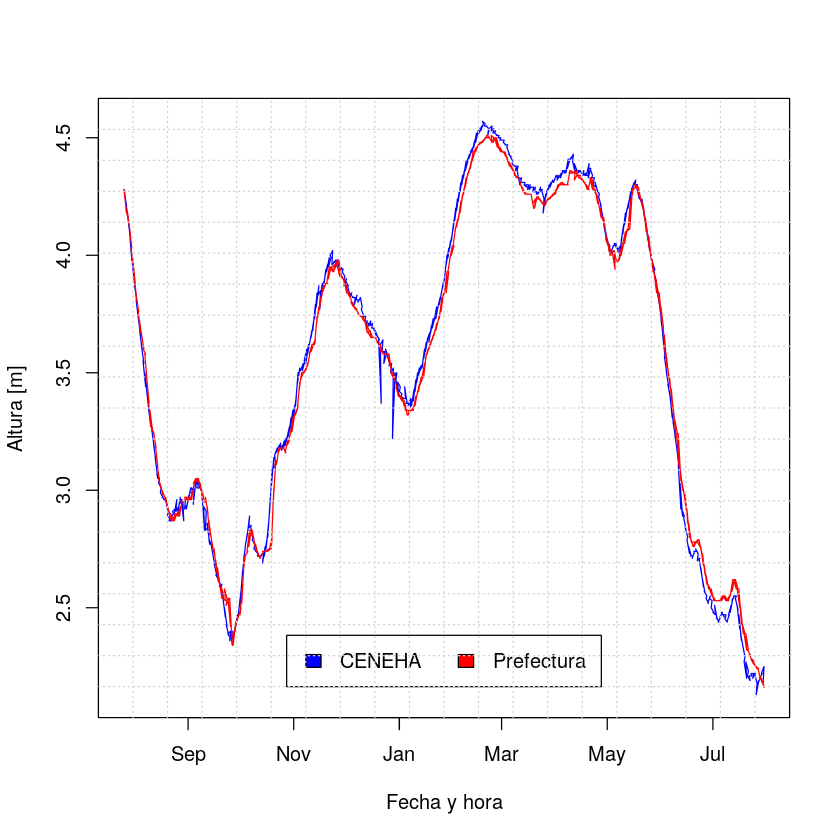

In [9]:
plot(FechayHora, AlturaCeneha, col="blue",xlab="Fecha y hora", ylab="Altura [m]", type="lines");lines(FechayHora, AlturaPrefectura,col="red");legend("bottom", inset=.05, c("CENEHA","Prefectura"), fill=c("blue","red"), horiz=TRUE);grid(nx = 20, ny = 20, col = "lightgray", lty = "dotted", lwd = par("lwd"), equilogs = TRUE)

- Eliminamos los outliers (promedio)
- Con los datos corregidos rehacemos el modelo

In [12]:
# Reemplazo los outliers por el promedio de sus valores vecinos que están correctos
AlturaPrefectura[166] = (AlturaPrefectura[167] + AlturaPrefectura[165])/2.0
AlturaCeneha[291] = (AlturaCeneha[290] + AlturaCeneha[292])/2.0
AlturaCeneha[306] = (AlturaCeneha[305] + AlturaCeneha[307])/2.0
modeloRioFixed = lm(AlturaPrefectura ~ AlturaCeneha)

## Modelo corregido

Warning message in plot.xy(xy, type, ...):
“plot type 'lines' will be truncated to first character”

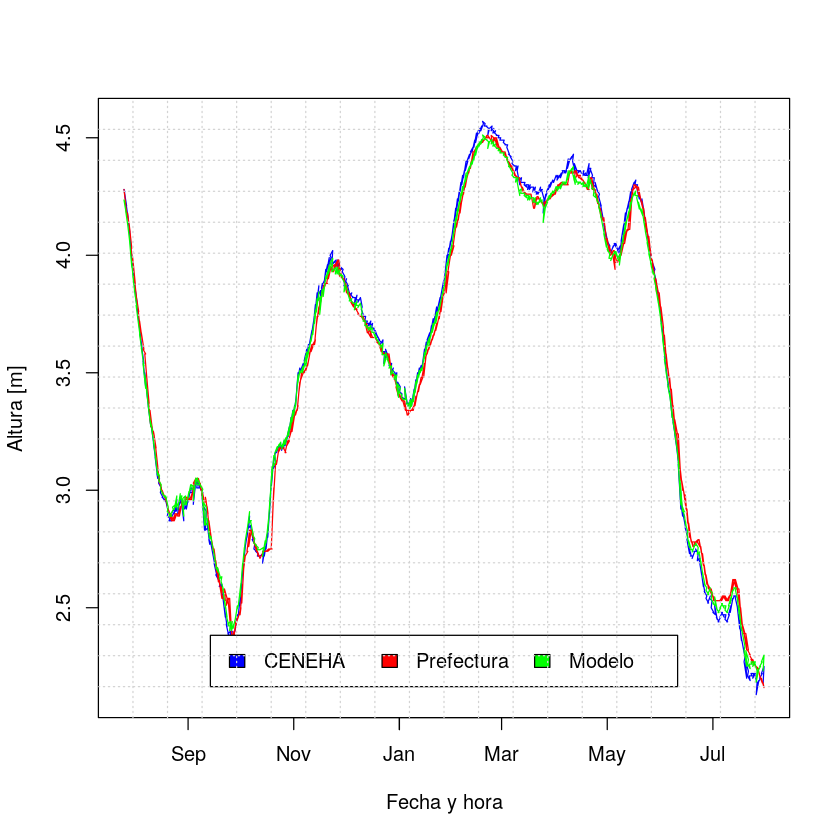

In [14]:
plot(FechayHora, AlturaCeneha, col="blue", xlab="Fecha y hora", ylab="Altura [m]", type="lines"); lines(FechayHora, AlturaPrefectura,col="red"); legend("bottom", inset=.05, c("CENEHA","Prefectura", "Modelo"), fill=c("blue","red", "green"), horiz=TRUE); grid(nx = 20, ny = 20, col = "lightgray", lty = "dotted", lwd = par("lwd"), equilogs = TRUE); lines(FechayHora, modeloRioFixed$fitted.values, col='green')

## Gráfico de dispersión

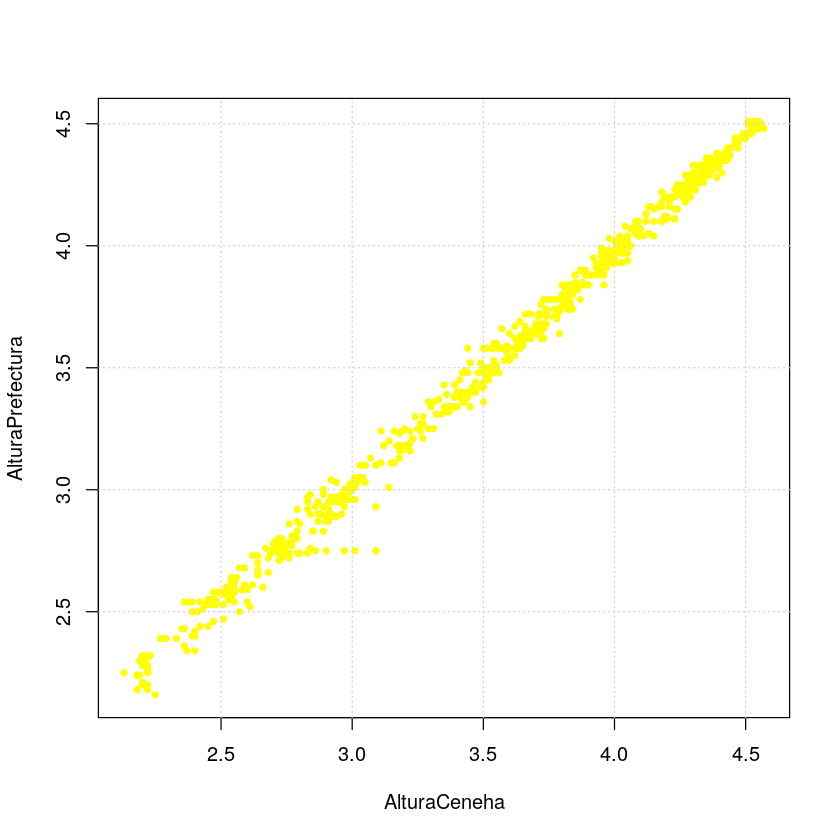

In [16]:
plot(AlturaPrefectura~AlturaCeneha,col='yellow',pch=20);grid(col = "lightgray", lty = "dotted", lwd = par("lwd"), equilogs = TRUE)

## Supuestos del modelo: normalidad

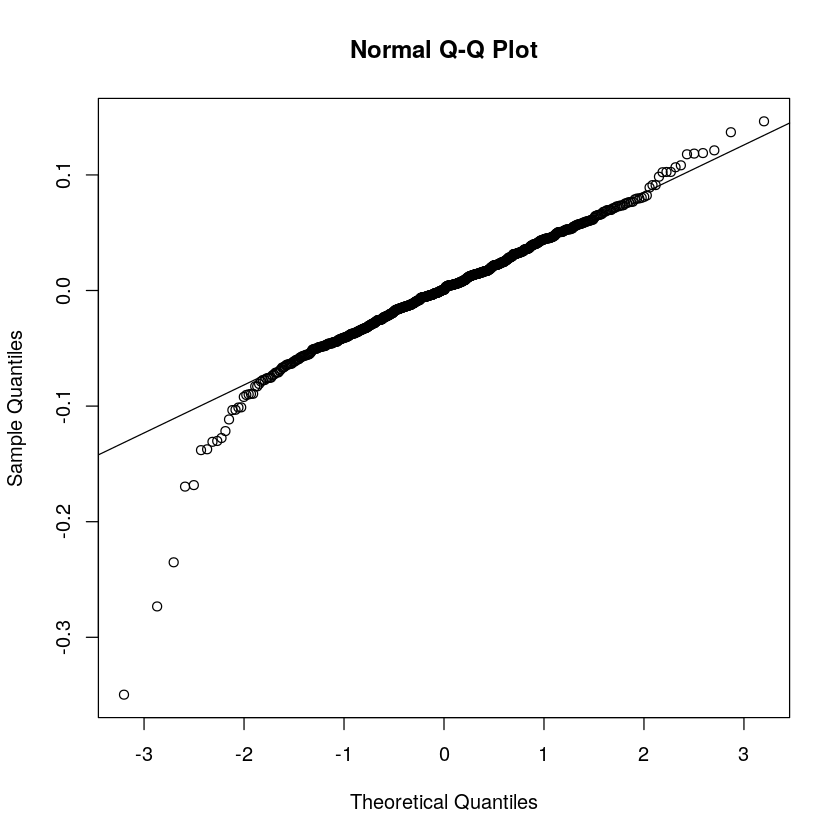

In [18]:
qqnorm(modeloRioFixed$residuals); qqline(modeloRioFixed$residuals)

## Varianza constante

In [21]:
library(car)
ncvTest(modeloRioFixed)

Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 84.58485, Df = 1, p = < 2.22e-16

## Independencia de los residuos
- Gráfica de rachas
- Gráfico de residuos adyacentes 

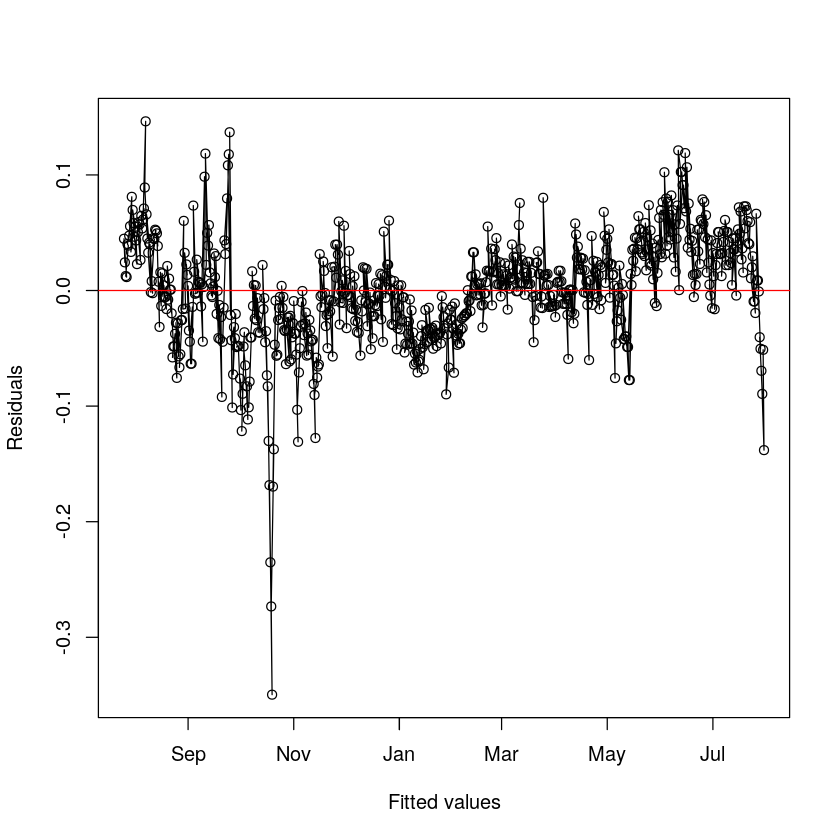

In [22]:
plot(FechayHora, modeloRioFixed$residuals, type='o',  ylab = 'Residuals', xlab = 'Fitted values',);abline(h=0,col='red')

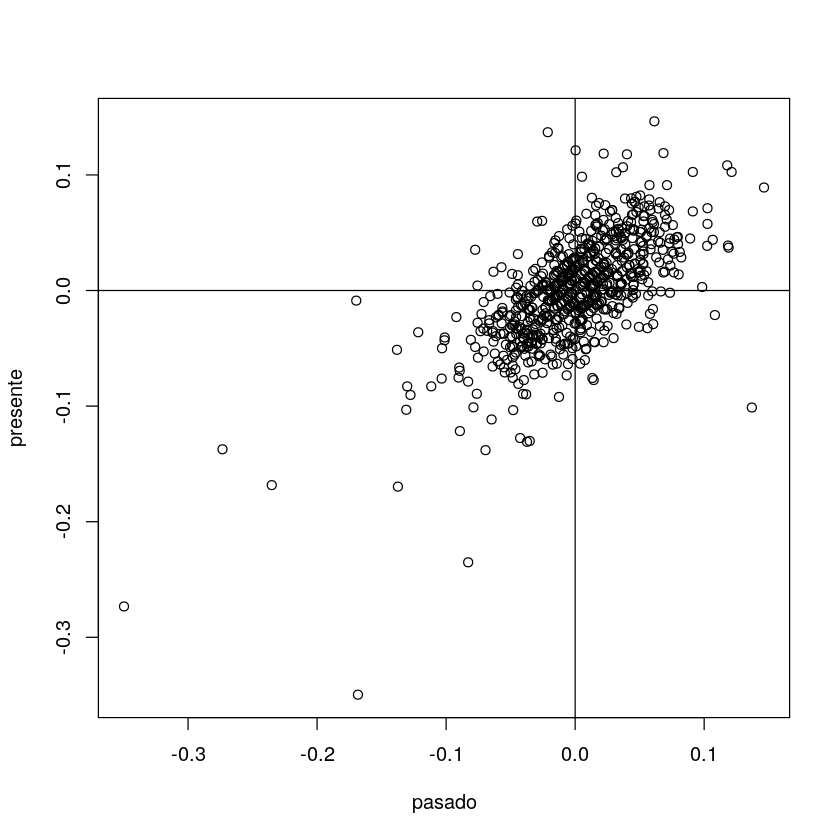

In [23]:
n = length(AlturaCeneha); residuos = modeloRioFixed$residuals; pasado = residuos[-n]; presente = residuos[-1]; plot(presente~pasado);abline(h = 0, v = 0)

## Estimamos 1° coeficiente de correlación serial (autocorrelación)

- H0: $\alpha = 0$
- H1: $\alpha \neq 0$

Ahora $\alpha$ será aproximado por el coeficiente de correlación serial $$r1 = c1/c0$$, que es similar a la pendiente de la recta en la regresión.

- Si r1 = 0 no existe correlación serial y por lo tanto el factor de ajuste es 1;
- Si r1 > 0 el factor de ajuste es más grande que 1;
- Si r1 < 0 el factor de ajuste es más chico que 1;

In [24]:
s = length(residuos)
c1 = sum(presente*pasado)/(n-1)
c0 = sum(presente^2)/(n-1)
(r1 = c1/c0)
abs(r1*sqrt(s))>qnorm(1-0.05/2)

[1] 0.6782063

[1] TRUE

Verdadero: 
 - coeficiente de correlacion no nulo 
 - -> hay correlacion entre los datos 
 - => **hago filtering**

## Variables filtradas

In [25]:
V = AlturaPrefectura[2:s] - r1 * AlturaPrefectura[1:(s-1)]
U = AlturaCeneha[2:s] -r1 * AlturaCeneha[1:(s-1)]
modeloF1 = lm(V~U); summary(modeloF1)


Call:
lm(formula = V ~ U)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.235479 -0.019059  0.000787  0.021110  0.149088 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.055075   0.006563   8.392 2.49e-16 ***
U           0.948482   0.005658 167.650  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03456 on 726 degrees of freedom
Multiple R-squared:  0.9748,	Adjusted R-squared:  0.9748 
F-statistic: 2.811e+04 on 1 and 726 DF,  p-value: < 2.2e-16


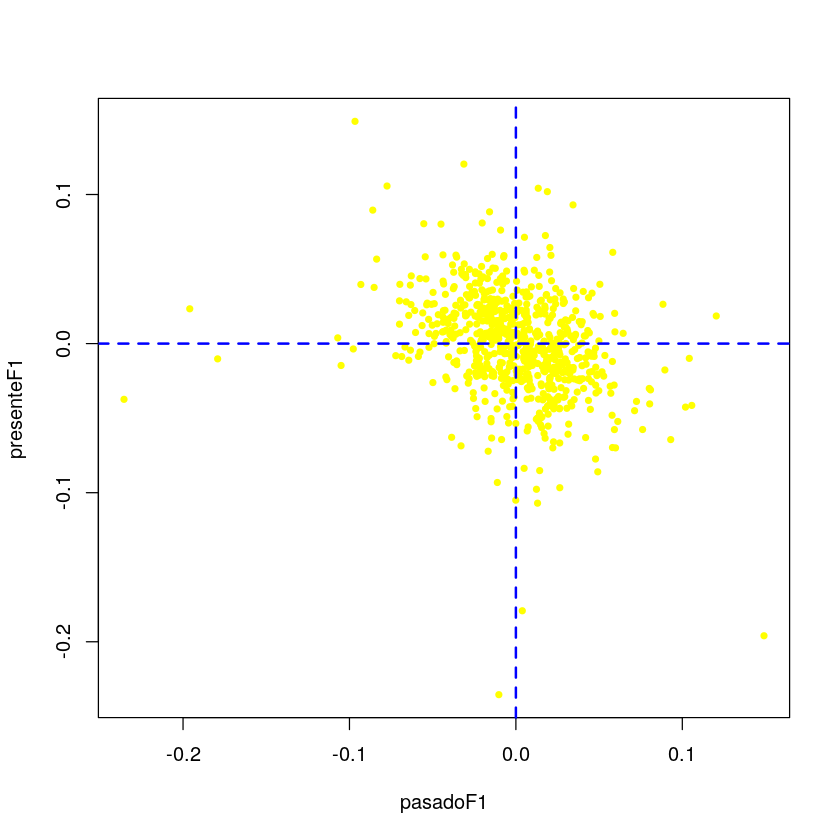

In [26]:
residuosF1 = modeloF1$residuals; sF1 = length(residuosF1); pasadoF1 = residuosF1[1:(sF1-1)]; presenteF1=residuosF1[2:(sF1)]; plot(presenteF1~pasadoF1,col='yellow',pch=20);abline(h=0,v=0,col='blue',lwd=2,lty=2)

### Repetimos el procedimiento 

In [27]:
#Hipotesis de que hay correlacion
c1F1=1/(sF1-1)*sum(presenteF1*pasadoF1)
c0F1=1/(sF1-1)*sum(residuosF1^2)
r1F1=c1F1/c0F1

#testeo si r1 es 0 o no, # es no 0 si es es TRUE
abs(r1F1*sqrt(sF1))>qnorm(1-0.05/2)

[1] TRUE


Call:
lm(formula = V2 ~ U2)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.238485 -0.017065 -0.000023  0.018988  0.118935 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.068318   0.006250   10.93   <2e-16 ***
U2          0.951702   0.004053  234.82   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03261 on 725 degrees of freedom
Multiple R-squared:  0.987,	Adjusted R-squared:  0.987 
F-statistic: 5.514e+04 on 1 and 725 DF,  p-value: < 2.2e-16


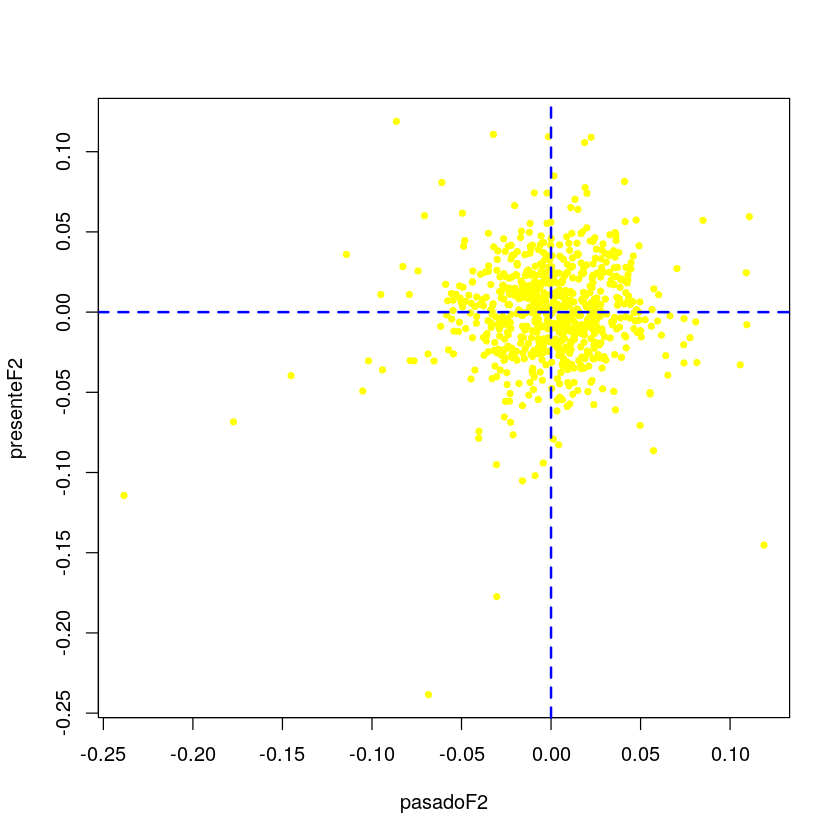

In [28]:
V2 = V[2:sF1] - r1F1 * V[1:(sF1-1)]
U2 = U[2:sF1] - r1F1 * U[1:(sF1-1)]

modeloF2 = lm(V2~U2)
summary(modeloF2)

#comparo el presente vs el pasado
residuosF2 = modeloF2$residuals
sF2 = length(residuosF2)
pasadoF2 = residuosF2[1:(sF2-1)]
presenteF2=residuosF2[2:(sF2)]

plot(presenteF2~pasadoF2,col='yellow',pch=20)
abline(h=0,v=0,col='blue',lwd=2,lty=2)

In [29]:
#hipotesis de que hay correlacion
c1F2=1/(sF2-1)*sum(presenteF2*pasadoF2)
c0F2=1/(sF2-1)*sum(residuosF2^2)

r1F2=c1F2/c0F2

#testeo si r1 es 0 o no, 
# es no 0 si es es TRUE
abs(r1F2*sqrt(sF2))>qnorm(1-0.05/2)

[1] TRUE


Call:
lm(formula = V3 ~ U3)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.233101 -0.018237  0.000429  0.019309  0.125483 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.063789   0.006227   10.24   <2e-16 ***
U3          0.951060   0.004388  216.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03253 on 724 degrees of freedom
Multiple R-squared:  0.9848,	Adjusted R-squared:  0.9848 
F-statistic: 4.698e+04 on 1 and 724 DF,  p-value: < 2.2e-16


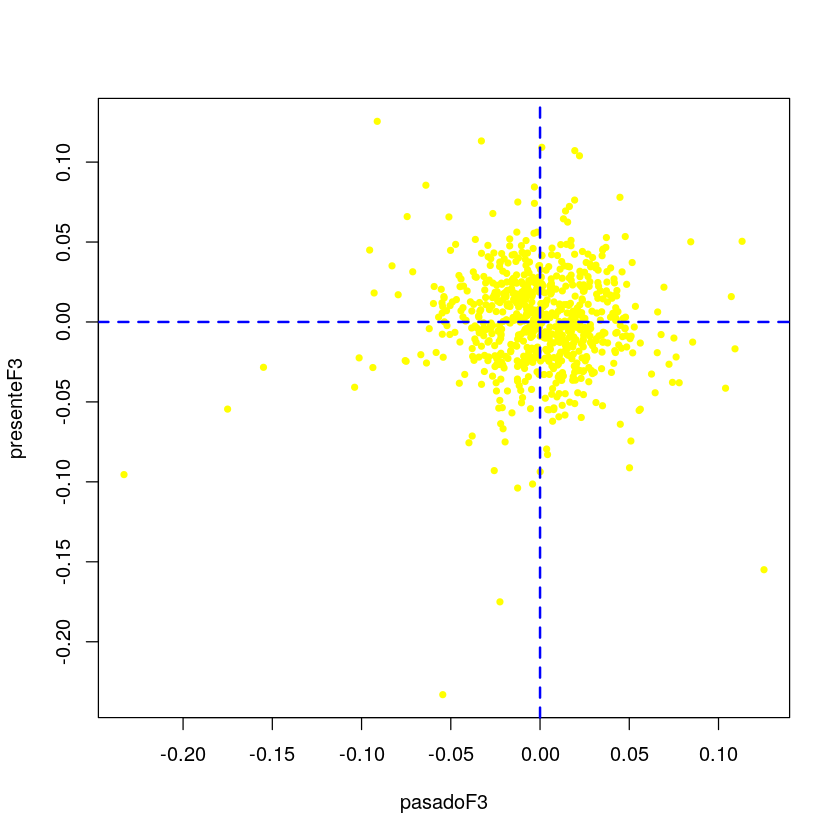

In [31]:
# 3er filtrado

V3 = V2[2:sF2] - r1F2 * V2[1:(sF2-1)]
U3 = U2[2:sF2] - r1F2 * U2[1:(sF2-1)]

modeloF3 = lm(V3~U3)
summary(modeloF3)
#comparo el presente vs el pasado
residuosF3 = modeloF3$residuals
sF3 = length(residuosF3)

pasadoF3 = residuosF3[1:(sF3-1)]
presenteF3=residuosF3[2:(sF3)]

plot(presenteF3~pasadoF3,col='yellow',pch=20)
abline(h=0,v=0,col='blue',lwd=2,lty=2)

### En el 3er filtrado

In [32]:
c1F3=1/(sF3-1)*sum(presenteF3*pasadoF3)
c0F3=1/(sF3-1)*sum(residuosF3^2)

r1F3=c1F3/c0F3

beta1 = 0.951060
SE_beta1 = 0.005658

#testeo si r1 es 0 (FALSE) o no (TRUE)
abs(r1F3*sqrt(sF3))>qnorm(1-0.05/2)

[1] FALSE

## Armamos el IC

- Hemos eliminado la correlación serial
- Resta construir el IC y que incluya el 1:

In [33]:
c(beta1 - qt(1-0.05/2,sF3-2)*SE_beta1, beta1 + qt(1-0.05/2,sF3-2)*SE_beta1)

[1] 0.939952 0.962168

## Submuestreamos con un dato mensual

Warning message in plot.xy(xy, type, ...):
“plot type 'lines' will be truncated to first character”

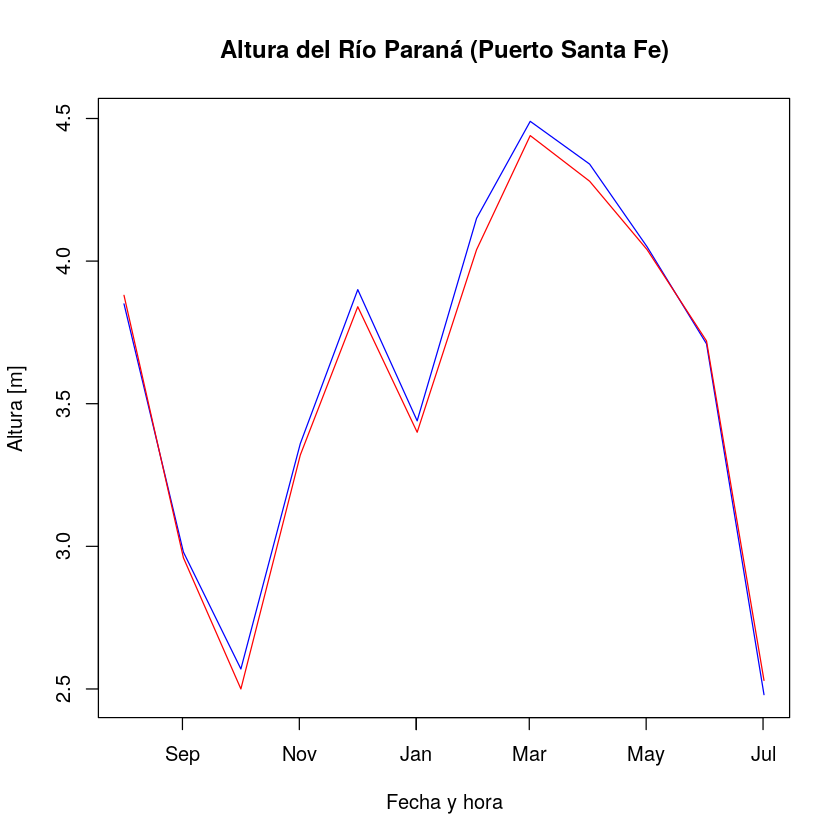

In [34]:
idx = (format(as.POSIXlt(FechayHora), "%d") =='01') & (format(as.POSIXlt(FechayHora), "%H") == '12');nuevadata = data.frame(FechayHora[idx], AlturaCeneha[idx], AlturaPrefectura[idx]);plot(FechayHora[idx], AlturaCeneha[idx], col="blue", main="Altura del Río Paraná (Puerto Santa Fe)",xlab="Fecha y hora", ylab="Altura [m]", type="lines");lines(FechayHora[idx], AlturaPrefectura[idx],col="red")

In [35]:
modeloHidrometro = lm(AlturaCeneha[idx]~AlturaPrefectura[idx])
summary(modeloHidrometro)


Call:
lm(formula = AlturaCeneha[idx] ~ AlturaPrefectura[idx])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.06691 -0.03353  0.00728  0.01723  0.06986 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -0.04149    0.07704  -0.538    0.602    
AlturaPrefectura[idx]  1.02021    0.02121  48.098 3.64e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04541 on 10 degrees of freedom
Multiple R-squared:  0.9957,	Adjusted R-squared:  0.9953 
F-statistic:  2313 on 1 and 10 DF,  p-value: 3.641e-13


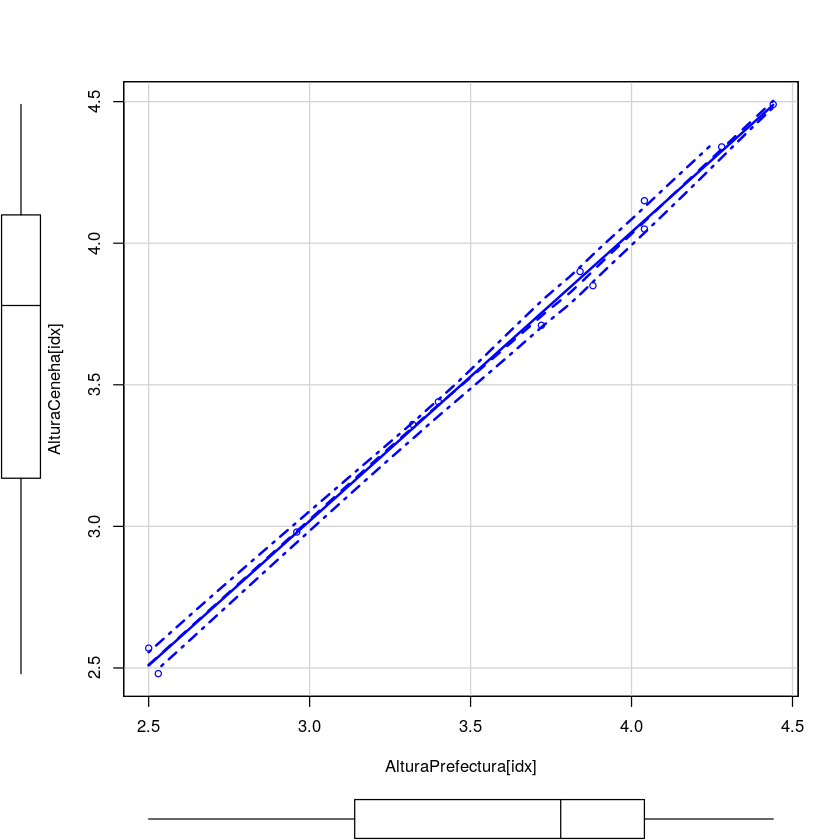

In [43]:
scatterplot(AlturaCeneha[idx]~AlturaPrefectura[idx], data=nuevadata) 

In [40]:
n = length(AlturaCeneha[idx])
residuos = modeloHidrometro$residuals
pasado = residuos[-n]   # elimina el último
presente = residuos[-1] # elimina el primero
c1 = sum(presente*pasado)/(n-1)
c0 = sum(presente^2)/(n-1)
(r1 = c1/c0)
abs(r1*sqrt(n))>qnorm(1-0.05/2)

[1] 0.3735782

[1] FALSE

## Intervalo de confianza

In [42]:
beta1 = 1.02021
SE_beta1 = 0.02121     

c(beta1 - qt(1-0.05/2,s-2)*SE_beta1, beta1 + qt(1-0.05/2,s-2)*SE_beta1)

[1] 0.9729512 1.0674688

# Conclusión

- El IC queda muy reducido ya que el SE la estimación del $\beta_1$ es muy pequeña
- La metodología es lo más básico que uno puede intentar: regresión lineal simple, con correlación (de 1 orden) en los errores. 
- Los errores no dan ni normales ni con varianza constante (el ncvTest arroja un p-value muy chiquito)
- Existen huecos en algunas series temporales por lo que no se cumple con el requisito
- Buscar una metodología que tenga en cuenta que lo que se comparan son series temporales

Gracias por su atención